# Notebook 02: Growth vs. Haven Dashboard (Brent vs. Gold)
#
# **Pair:** Brent Crude Oil Futures (/BZ) vs. Gold Futures (/GC)
# **Thesis:** Tracking the "Geopolitics/Inflation vs. Growth" divergence.
#
# **Classic Correlation (Positive):**
# 1.  **Inflation/Weak USD:** A weak dollar or high inflation lifts *all* real assets. (/BZ rises, /GC rises).
# 2.  **Geopolitical Shock:** A Mideast conflict threatens oil supply (/BZ rises) AND sparks a flight to safety (/GC rises).
#
# **Decorrelation (The "Arbitrage"):**
# 1.  **Global Recession:** Fears of a slowdown *crush* industrial/transport demand for oil (/BZ falls) BUT trigger a flight-to-safety *and* expectations of central bank easing (/GC rises).
#
# **Proxies Used:**
# * `/BZ=F` (Brent Future) -> `BNO` (Brent Oil ETF for clean price history)
# * `/GC=F` (Gold Future)   -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `NPMI`: ISM Manufacturing PMI. **This is the #1 global growth proxy.** Below 50 = contraction (bearish Oil, bullish Gold).
# * `CPILFESL`: U.S. Core CPI. The "stagflation" signal. If this is high while NPMI is low, it's very bullish for Gold.
# * `DTWEXBGS`: Trade-Weighted U.S. Dollar Index.

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [2]:
# Cell 2: API & LLM Configuration (Refactored)
#
# Set up API keys, LLM endpoints, and asset tickers.
# ADDED: Volatility tickers GVZCLS (Gold) and OVXCLS (Oil).

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["GLD", "BNO"]
FRED_SERIES_IDS = [
    "IPMAN", "CPILFESL", "DTWEXBGS", # Core Macro Drivers
    "GVZCLS",                       # CBOE Gold Volatility Index
    "OVXCLS"                        # CBOE Crude Oil Volatility Index
] 

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['GLD', 'BNO'] and ['IPMAN', 'CPILFESL', 'DTWEXBGS', 'GVZCLS', 'OVXCLS']


In [3]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (GLD, BNO).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")


Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_1126902/920599846.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)


[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker        BNO         GLD
Date                         
2025-10-28  29.08  364.380005
2025-10-29  29.34  363.000000
2025-10-30  29.25  370.130005
2025-10-31  29.57  368.119995
2025-11-03  29.67  368.779999


In [4]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: NPMI and CPILFESL are monthly, so ffill() will be important.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            IPMAN  CPILFESL  DTWEXBGS  GVZCLS  OVXCLS
2025-10-27    NaN       NaN  121.2002   23.94   38.96
2025-10-28    NaN       NaN  121.0349   24.03   37.18
2025-10-29    NaN       NaN  120.9290   24.70   37.14
2025-10-30    NaN       NaN  121.6650   24.82   34.74
2025-10-31    NaN       NaN  121.7715   22.66   36.20


In [5]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill monthly data.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (CRITICAL for monthly PMI/CPI data)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
              BNO         GLD     IPMAN  CPILFESL  DTWEXBGS  GVZCLS  OVXCLS
2025-10-28  29.08  364.380005  101.0388   330.542  121.0349   24.03   37.18
2025-10-29  29.34  363.000000  101.0388   330.542  120.9290   24.70   37.14
2025-10-30  29.25  370.130005  101.0388   330.542  121.6650   24.82   34.74
2025-10-31  29.57  368.119995  101.0388   330.542  121.7715   22.66   36.20
2025-11-03  29.67  368.779999  101.0388   330.542  121.7715   22.66   36.20


In [6]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
# This allows us to plot PMI (e.g., 52.0) on the same chart as GLD (e.g., 200).

try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                BNO           GLD         IPMAN      CPILFESL      DTWEXBGS        GVZCLS        OVXCLS
count  1.319000e+03  1.319000e+03  1.319000e+03  1.319000e+03  1.319000e+03  1.319000e+03  1.319000e+03
mean   1.723834e-16 -4.309584e-17 -1.939313e-15 -1.723834e-16 -3.533859e-15 -4.309584e-17  3.016709e-16
std    1.000379e+00  1.000379e+00  1.000379e+00  1.000379e+00  1.000379e+00  1.000379e+00  1.000379e+00
min   -2.944721e+00 -1.021860e+00 -4.127030e+00 -1.786529e+00 -1.976777e+00 -2.310104e+00 -1.762770e+00
25%   -4.115334e-01 -6.713021e-01 -2.810009e-01 -8.139219e-01 -8.756664e-01 -5.803974e-01 -6.761667e-01
50%    3.700952e-01 -4.638998e-01  2.615788e-01  2.168022e-01  1.880490e-01 -1.145754e-01 -2.153920e-01
75%    6.916287e-01  4.163546e-01  6.636573e-01  8.669455e-01  6.326466e-01  5.173669e-01  5.542852e-01
max    1.734392e+00  3.838494e+00  1.075762e+00  1.436566e+00  2.184471e+00  5.417061e+00  4.561994e+00


In [7]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of GLD divided by the price of BNO (Brent).
#     A RISING ratio signals a "Recession" or "Stagflation" regime
#     (Gold outperforming Oil).
# * Spread (Normalized): The normalized Z-score of GLD minus
#     normalized Z-score of BNO. This shows the *magnitude* of the divergence.

try:
    # 1. Price Ratio (The Core Signal)
    df['GLD_BNO_Ratio'] = df['GLD'] / df['BNO']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['GLD_BNO_Spread_Norm'] = df_normalized['GLD'] - df_normalized['BNO']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['GLD_BNO_Ratio', 'GLD_BNO_Spread_Norm']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            GLD_BNO_Ratio  GLD_BNO_Spread_Norm
2025-10-28      12.530262             2.636908
2025-10-29      12.372188             2.564096
2025-10-30      12.654017             2.717645
2025-10-31      12.449104             2.622019
2025-11-03      12.429390             2.616989


In [8]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of GLD and BNO.
# This quantifies the regime:
# * Positive Correlation = Inflation / Geopolitics
# * Negative Correlation = Recession / Growth Scare

try:
    # First, get daily percentage returns
    df['GLD_pct'] = df['GLD'].pct_change()
    df['BNO_pct'] = df['BNO'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['GLD_pct'].rolling(window=30).corr(df['BNO_pct'])
    df['Corr_90D'] = df['GLD_pct'].rolling(window=90).corr(df['BNO_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-28 -0.066869 -0.052872
2025-10-29 -0.083587 -0.055727
2025-10-30 -0.089146 -0.057759
2025-10-31 -0.089176 -0.071975
2025-11-03 -0.090246 -0.073748


In [9]:
# Cell 8a: Feature Engineering - Historical Volatility (NEW)
#
# Calculate 30-day Historical (Realized) Volatility (HV) for our assets.
# This will be compared against Implied Volatility (IV).

try:
    # Calculate 30-day rolling HV (annualized)
    df['GLD_HV_30D'] = df['GLD_pct'].rolling(window=30).std() * np.sqrt(252)
    df['BNO_HV_30D'] = df['BNO_pct'].rolling(window=30).std() * np.sqrt(252)

    print("✅ Cell 8a: Historical Volatility (HV) calculated.")
    print(df[['GLD_HV_30D', 'BNO_HV_30D']].tail())

except Exception as e:
    print(f"❌ Cell 8a: HV calculation failed: {e}")

✅ Cell 8a: Historical Volatility (HV) calculated.
            GLD_HV_30D  BNO_HV_30D
2025-10-28    0.296529    0.259546
2025-10-29    0.295567    0.260338
2025-10-30    0.298865    0.260165
2025-10-31    0.299138    0.259285
2025-11-03    0.296012    0.259505


In [10]:
# Cell 8b: Feature Engineering - IV Rank (NEW)
#
# Calculate the 1-year (252-day) Implied Volatility Rank (IVR).
# This tells us if the current IV is "high" or "low" relative to its own history.
# IVR = 100 * (Current IV - 52wk Low) / (52wk High - 52wk Low)

try:
    # Calculate 252-day rolling min/max for Gold Vol
    df['GVZ_min_252D'] = df['GVZCLS'].rolling(window=252).min()
    df['GVZ_max_252D'] = df['GVZCLS'].rolling(window=252).max()
    
    # Calculate 252-day rolling min/max for Oil Vol
    df['OVX_min_252D'] = df['OVXCLS'].rolling(window=252).min()
    df['OVX_max_252D'] = df['OVXCLS'].rolling(window=252).max()
    
    # Calculate IV Rank for both
    df['GVZ_IVR_252D'] = 100 * (df['GVZCLS'] - df['GVZ_min_252D']) / (df['GVZ_max_252D'] - df['GVZ_min_252D'])
    df['OVX_IVR_252D'] = 100 * (df['OVXCLS'] - df['OVX_min_252D']) / (df['OVX_max_252D'] - df['OVX_min_252D'])

    print("✅ Cell 8b: Implied Volatility Rank (IVR) calculated.")
    print(df[['GVZCLS', 'GVZ_IVR_252D', 'OVXCLS', 'OVX_IVR_252D']].tail())

except Exception as e:
    print(f"❌ Cell 8b: IV Rank calculation failed: {e}")

✅ Cell 8b: Implied Volatility Rank (IVR) calculated.
            GVZCLS  GVZ_IVR_252D  OVXCLS  OVX_IVR_252D
2025-10-28   24.03     52.159650   37.18     22.023134
2025-10-29   24.70     55.822854   37.14     21.932411
2025-10-30   24.82     56.478950   34.74     16.489000
2025-10-31   22.66     44.669218   36.20     19.800408
2025-11-03   22.66     44.669218   36.20     19.800408


In [11]:
# Cell 8c: Feature Engineering - VRP & Signal Velocity (NEW)
#
# Calculate the Volatility Risk Premium (VRP) and Signal Velocity.
# VRP = Implied Vol (IV) - Historical Vol (HV).
#     Positive VRP = Options are "expensive" (Good for selling premium).
#
# Signal Velocity = 5-day change in the normalized spread.

try:
    # 1. Volatility Risk Premium (VRP)
    df['GLD_VRP'] = df['GVZCLS'] - df['GLD_HV_30D']
    df['BNO_VRP'] = df['OVXCLS'] - df['BNO_HV_30D']
    
    # 2. Signal Velocity
    df['Signal_Velocity_5D'] = df['GLD_BNO_Spread_Norm'].diff(5)

    print("✅ Cell 8c: VRP and Signal Velocity calculated.")
    print(df[['GLD_VRP', 'BNO_VRP', 'Signal_Velocity_5D']].tail())
    
    # Drop NaNs created by all the new rolling windows to clean the final df
    df = df.dropna()

except Exception as e:
    print(f"❌ Cell 8c: VRP/Velocity calculation failed: {e}")

✅ Cell 8c: VRP and Signal Velocity calculated.
              GLD_VRP    BNO_VRP  Signal_Velocity_5D
2025-10-28  23.733471  36.920454           -0.452400
2025-10-29  24.404433  36.879662           -0.371435
2025-10-30  24.521135  34.479835           -0.081811
2025-10-31  22.360862  35.940715           -0.142275
2025-11-03  22.363988  35.940495            0.039478


Plotting Cell 9: Core Thesis...


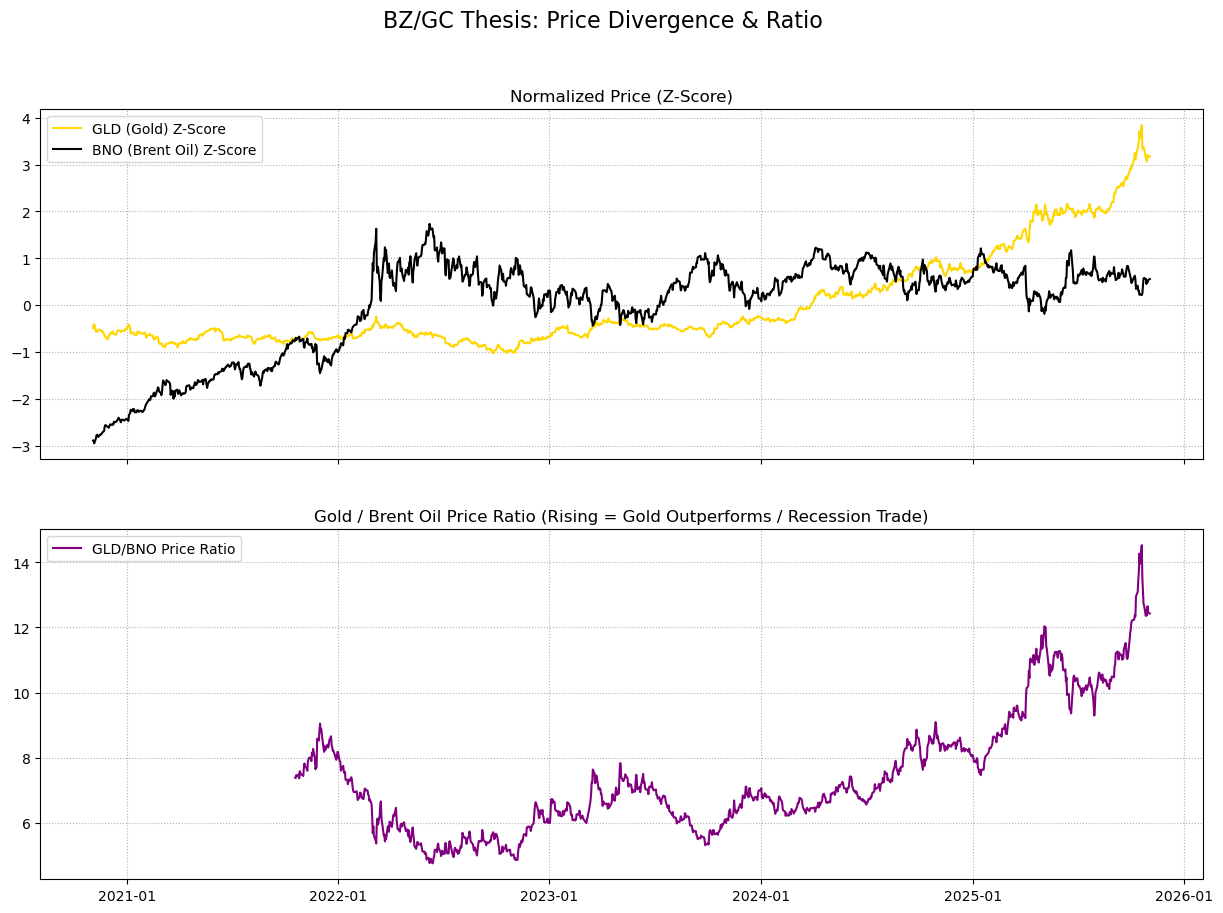

In [12]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of GLD vs. BNO.
# Plot 2: The GLD/BNO Ratio.
#
# This chart shows *what* is happening. When they cross, the ratio
# (Plot 2) changes direction. A rising ratio is the "recession" trade.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('BZ/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['BNO'], label='BNO (Brent Oil) Z-Score', color='black')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['GLD_BNO_Ratio'], label='GLD/BNO Price Ratio', color='purple')
    ax2.set_title('Gold / Brent Oil Price Ratio (Rising = Gold Outperforms / Recession Trade)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver (Growth)...


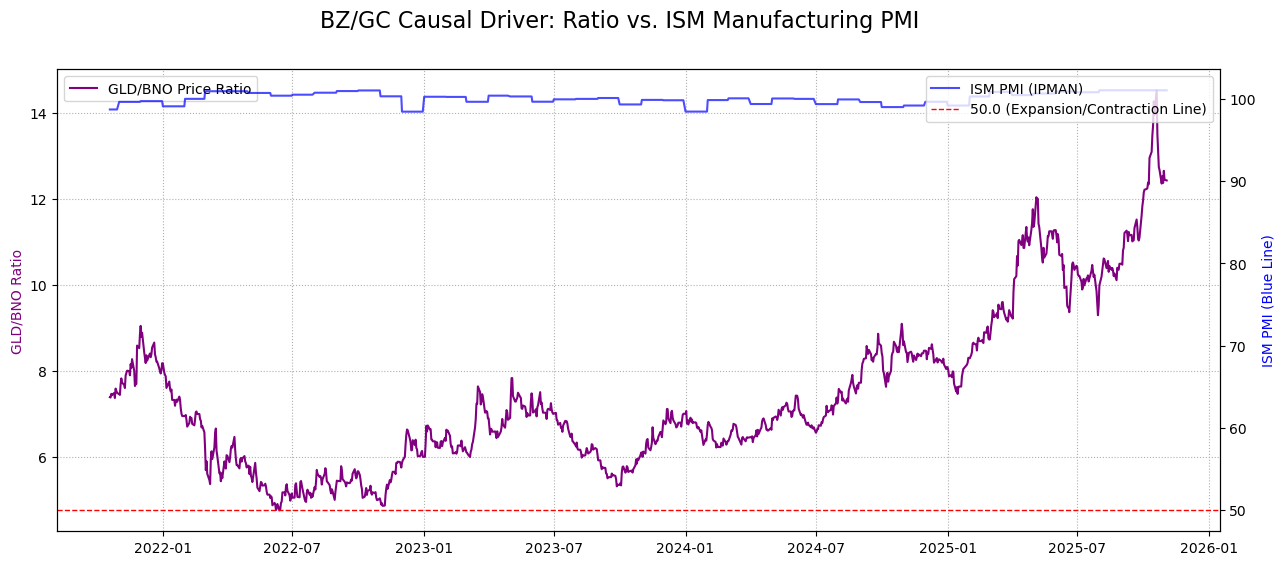

In [13]:
# Cell 10: Visualization - Causal Driver (Global Growth)
#
# Plot the GLD/BNO Ratio vs. the ISM Manufacturing PMI (NPMI).
#
# This chart shows *why* it's happening.
# Thesis: The ratio (purple) should move INVERSELY to the PMI (blue).
# When PMI falls below 50 (contraction), the ratio should rise
# as the "Recession" trade (Long Gold, Short Oil) works.

try:
    print("Plotting Cell 10: Causal Driver (Growth)...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('BZ/GC Causal Driver: Ratio vs. ISM Manufacturing PMI', fontsize=16)

    # Plot 1: GLD/BNO Ratio
    ax1.plot(df.index, df['GLD_BNO_Ratio'], label='GLD/BNO Price Ratio', color='purple')
    ax1.set_ylabel('GLD/BNO Ratio', color='purple')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')
    
    # Plot 2: ISM PMI (NPMI) on a shared X-axis, different Y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['IPMAN'], label='ISM PMI (IPMAN)', color='blue', alpha=0.7)
    ax2.axhline(50, color='red', linestyle='--', linewidth=1, label='50.0 (Expansion/Contraction Line)')
    ax2.set_ylabel('ISM PMI (Blue Line)', color='blue')
    ax2.legend(loc='upper right')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


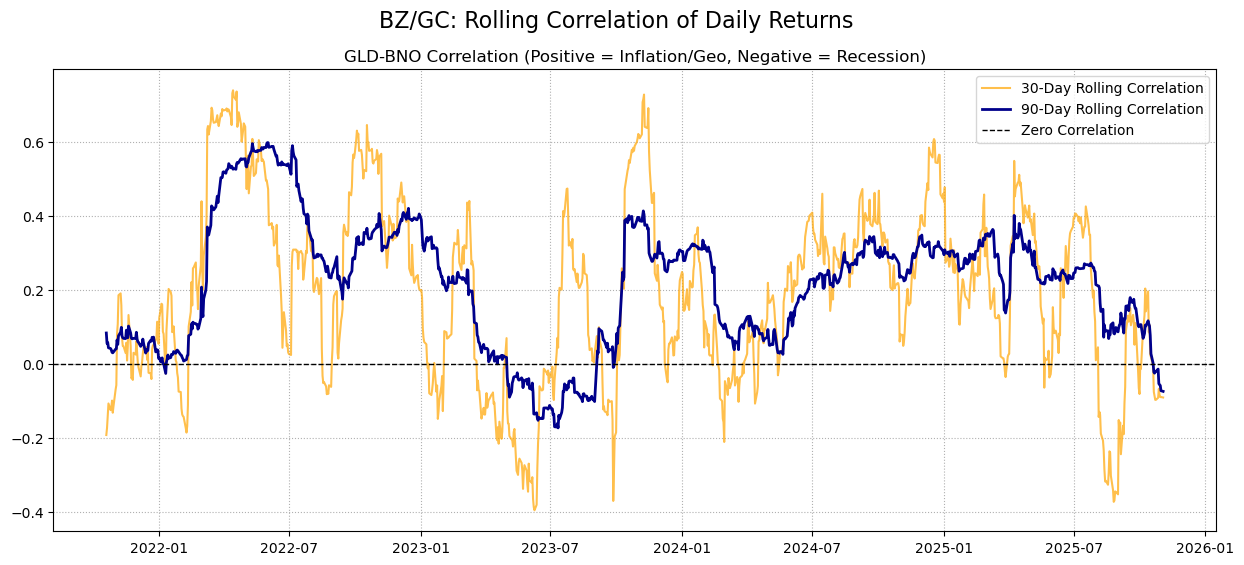

In [14]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * Positive = Inflation/Geopolitics
# * Negative = Recession

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('BZ/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('GLD-BNO Correlation (Positive = Inflation/Geo, Negative = Recession)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

Plotting Cell 11a: Volatility Dashboard...


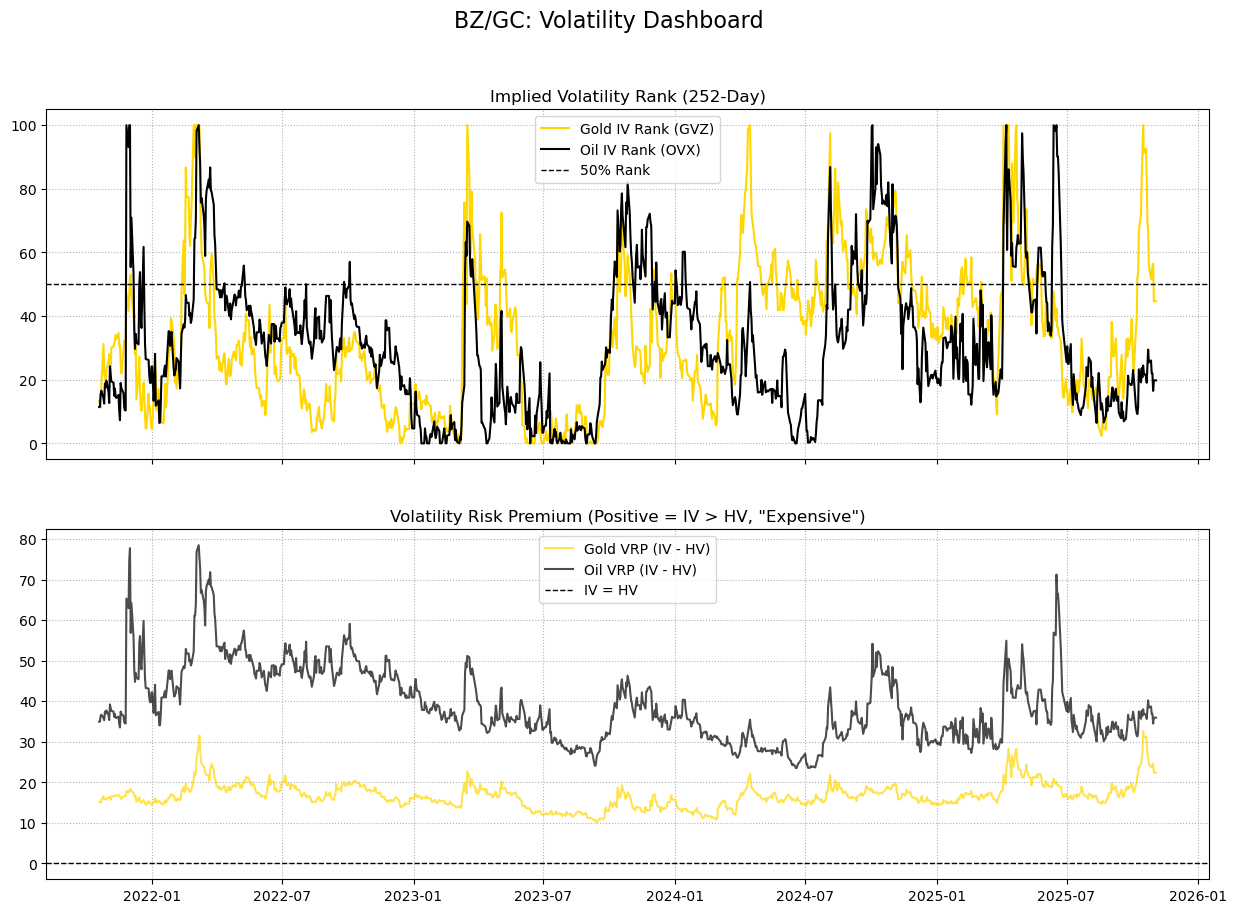

In [15]:
# Cell 11a: Visualization - Volatility Dashboard (NEW)
#
# Plot the IV Rank and the Volatility Risk Premium (VRP) for both assets.
# This chart tells us *when* to put on a trade and *what kind*.

try:
    print("Plotting Cell 11a: Volatility Dashboard...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('BZ/GC: Volatility Dashboard', fontsize=16)

    # Plot 1: IV Rank (Tells you if vol is "high" or "low")
    ax1.plot(df.index, df['GVZ_IVR_252D'], label='Gold IV Rank (GVZ)', color='gold')
    ax1.plot(df.index, df['OVX_IVR_252D'], label='Oil IV Rank (OVX)', color='black')
    ax1.axhline(50, color='black', linestyle='--', linewidth=1, label='50% Rank')
    ax1.set_title('Implied Volatility Rank (252-Day)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Volatility Risk Premium (IV vs HV)
    ax2.plot(df.index, df['GLD_VRP'], label='Gold VRP (IV - HV)', color='gold', alpha=0.7)
    ax2.plot(df.index, df['BNO_VRP'], label='Oil VRP (IV - HV)', color='black', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='IV = HV')
    ax2.set_title('Volatility Risk Premium (Positive = IV > HV, "Expensive")')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11a: Volatility plotting failed: {e}")

In [16]:
# Cell 12: LLM Analyst Synthesis (Refactored for Reasoning)
#
# This cell is for YOU. It runs the full qualitative analysis for
# the complex pairs trade.
# NEW: Re-added the "Explain your reasoning" commands to get
#      the full, verbose output.

try:
    print("Sending data to LLM for full analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # --- Create Data Summary ---
    
    # 1. Macro Theme Summary
    macro_summary = f"""
--- MACRO THEME (Pair: BZ/GC) ---
- **Thematic Bias:** Growth vs. Haven
- **Signal Strength (Z-Score):** {latest_data['GLD_BNO_Spread_Norm']:.2f}
- **Signal Velocity (5D Change):** {latest_data['Signal_Velocity_5D']:.2f}
- **Regime Type (90D Corr):** {latest_data['Corr_90D']:.3f} (Negative = Recession, Positive = Inflation/Geo)
- **Growth Driver (ISM PMI):** {latest_data['IPMAN']:.1f} (Critical level: 50)
- **Inflation Driver (Core CPI):** {latest_data['CPILFESL']:.2f}%
"""
    
    # 2. Volatility Dashboard Summary
    vol_summary = f"""
--- VOLATILITY DASHBOARD ---
- **Gold (GLD) IV Rank:** {latest_data['GVZ_IVR_252D']:.1f}%
- **Gold (GLD) VRP:** {latest_data['GLD_VRP']:.2f} (Positive = "Expensive")
- **Oil (BNO) IV Rank:** {latest_data['OVX_IVR_252D']:.1f}%
- **Oil (BNO) VRP:** {latest_data['BNO_VRP']:.2f} (Positive = "Expensive")
"""
    
    # 3. Determine Thematic Bias
    if latest_data['GLD_BNO_Spread_Norm'] > 0:
        directional_bias = "Long GLD / Short BNO"
    else:
        directional_bias = "Long BNO / Short GLD"

    # --- Create the LLM Prompt ---
    prompt = f"""
**Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.

**Your Available Strategies:**
* Bull_Put_Spread, Bear_Call_Spread, Iron_Condor (Sell Premium)
* Calendar_Spread, Diagonal_Spread, Double_Diagonal_Spread (Buy Vega)
* No_Trade

**Latest OSINT Data:**
{macro_summary}
{vol_summary}

**Your Task (Provide a detailed 3-part recommendation):**
1.  **Macro Thesis Check:** What is the primary thematic driver?
    * Is this a Recession Signal (`90D Corr` < 0, `IPMAN` < 50)?
    * Is this a Stagflation Signal (`IPMAN` < 50, `Core CPI` high)?
    * Or is this an Inflation/Geo Signal (`90D Corr` > 0)?
    * The current thematic bias based on the Z-Score is **{directional_bias}**.
    * **Explain your reasoning in detail.**
2.  **Volatility Regimes:** Analyze the volatility for *both* legs of the trade.
    * **GLD:** IV Rank is {latest_data['GVZ_IVR_252D']:.1f}% ({"High/Expensive" if latest_data['GVZ_IVR_252D'] > 50 else "Low/Cheap"}).
    * **BNO (Oil):** IV Rank is {latest_data['OVX_IVR_252D']:.1f}% ({"High/Expensive" if latest_data['OVX_IVR_252D'] > 50 else "Low/Cheap"}).
    * **Explain *why* this combination of volatility regimes is important for a pairs trade.**
3.  **Strategy Route (Pairs Trade):** Combine the thesis and the two vol regimes to build the optimal *pairs trade* for the **{directional_bias}** theme.
    * **Explain your logic for each leg of the trade** and why it is the best fit from the strategy list.
    
**CRITICAL:** Conclude your *entire* analysis with two, single, parsable lines:
ROUTED_STRATEGY_GLD: [strategy_name_for_GLD_leg]
ROUTED_STRATEGY_BNO: [strategy_name_for_BNO_leg]
(If a leg is not traded, use: No_Trade)
"""
    
    # Get LLM response
    llm_analyst_report = ask_llm(prompt) # This is the full, verbose report
    
    # --- Store data for subsequent cells ---
    latest_trade_data = latest_data.to_dict()
    latest_trade_data['Date'] = latest_data.name 
    latest_trade_rec = {"directional_bias": directional_bias} # Store bias
    
    print("\n--- 🤖 LLM ANALYST REPORT ---")
    print(llm_analyst_report)
    print("---------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analyst synthesis failed: {e}")

Sending data to LLM for full analysis...



--- 🤖 LLM ANALYST REPORT ---
### 1. Macro Thesis Check

The primary thematic driver in this scenario is **Growth vs. Haven** with a **Long GLD / Short BNO** bias based on the Z-Score of 2.62. This indicates that investors are favoring safe-haven assets over riskier ones, which aligns more closely with a haven-seeking behavior rather than a recession or stagflation signal.

- **Recession Signal:** The `90D Corr` is -0.074, indicating a negative correlation with economic recessions. However, the `Growth Driver (ISM PMI)` at 101.0 suggests strong growth conditions, which contradicts a recessionary environment.
- **Stagflation Signal:** The `Growth Driver (ISM PMI)` is above the critical level of 50, and while inflation (`Core CPI`) is high, it does not align with stagflation as there's no indication of economic contraction.
- **Inflation/Geo Signal:** There isn't a strong signal for an inflationary or geopolitical environment given the current data.

### 2. Volatility Regimes

Both GLD (

In [17]:
# Cell 13: Signal Extraction (NEW)
#
# This cell is for the MACHINE. It *parses* the report from Cell 12
# to find the two strategy recommendations.
# FIX: Added .strip(" *") to remove markdown formatting.

try:
    print("Parsing analyst report for clean signals...")
    
    strategy_gld = "No_Trade"
    strategy_bno = "No_Trade"
    
    # Simple string parsing
    for line in llm_analyst_report.split('\n'):
        # Strip leading/trailing spaces AND asterisks from the line
        clean_line = line.strip(" *") 
        
        if clean_line.startswith("ROUTED_STRATEGY_GLD:"):
            # Split and strip any remaining/internal asterisks
            strategy_gld = clean_line.split(":", 1)[1].strip().strip("*")
        
        if clean_line.startswith("ROUTED_STRATEGY_BNO:"):
            # Split and strip any remaining/internal asterisks
            strategy_bno = clean_line.split(":", 1)[1].strip().strip("*")
            
    # --- Store for Cells 14 and 15 ---
    latest_trade_rec['strategy_gld'] = strategy_gld
    latest_trade_rec['strategy_bno'] = strategy_bno
    
    print(f"✅ Cell 13: Parsed Strategy (GLD): {strategy_gld}")
    print(f"✅ Cell 13: Parsed Strategy (BNO): {strategy_bno}")

except Exception as e:
    print(f"❌ Cell 13: String parser failed: {e}")
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['strategy_gld'] = "No_Trade"
    latest_trade_rec['strategy_bno'] = "No_Trade"

Parsing analyst report for clean signals...
✅ Cell 13: Parsed Strategy (GLD): Bear_Call_Spread
✅ Cell 13: Parsed Strategy (BNO): Bull_Put_Spread


In [18]:
# Cell 14: Position Sizing (NEW)
#
# Apply Step 3 of your thesis ("Trade & risk discipline").
# This cell sizes *both legs* of the pairs trade, splitting the
# total risk allocation (e.g., 50bps total -> 25bps per leg).

import math

# --- Define Your Risk Parameters ---
ACCOUNT_VALUE = 100000.00  # Your total trading capital
RISK_BPS_PER_TRADE = 50  # 50 bps = 0.50% risk for the *entire idea*
RISK_BPS_PER_LEG = RISK_BPS_PER_TRADE / 2 # 25 bps per leg

# --- Define Approx. Risk-Per-Contract (Based on your Specs) ---
RISK_PER_CONTRACT = {
    "Bull_Put_Spread": 350,
    "Bear_Call_Spread": 350,
    "Iron_Condor": 300,
    "Calendar_Spread": 150,
    "Diagonal_Spread": 200,
    "Double_Diagonal_Spread": 100,
    "No_Trade": 0
}

def get_leg_size(strategy_name, risk_bps):
    """Calculates contract size for a single trade leg."""
    if strategy_name == "No_Trade" or strategy_name not in RISK_PER_CONTRACT:
        return 0, 0.0
        
    risk_per_trade_usd = ACCOUNT_VALUE * (risk_bps / 10000.0)
    risk_per_unit = RISK_PER_CONTRACT.get(strategy_name, risk_per_trade_usd)
    
    if risk_per_unit <= 0:
         contracts = 0
    else:
        contracts = math.floor(risk_per_trade_usd / risk_per_unit)
        contracts = max(1, contracts) # Ensure at least 1 contract
        
    return contracts, risk_per_trade_usd

try:
    # --- Get Data from Cell 13 ---
    strategy_gld = latest_trade_rec['strategy_gld']
    strategy_bno = latest_trade_rec['strategy_bno']
    
    # --- Size Each Leg ---
    contracts_gld, risk_gld = get_leg_size(strategy_gld, RISK_BPS_PER_LEG)
    contracts_bno, risk_bno = get_leg_size(strategy_bno, RISK_BPS_PER_LEG)
    
    # --- Store for Cell 15 ---
    latest_trade_rec['contracts_gld'] = contracts_gld
    latest_trade_rec['contracts_bno'] = contracts_bno
    
    # --- Print Final Trade Ticket ---
    print("--- ✅ FINAL PAIRS TRADE TICKET ---")
    print(f"Date:       {latest_trade_data['Date'].strftime('%Y-%m-%d')}")
    print(f"Theme:      Growth vs. Haven (BZ/GC)")
    print(f"Bias:       {latest_trade_rec['directional_bias']}")
    print(f"Total Risk: {RISK_BPS_PER_TRADE} bps on ${ACCOUNT_VALUE:,.2f} = ${risk_gld + risk_bno:,.2f} max risk")
    print("---")
    print(f"LEG 1 (Gold):")
    print(f"  Strategy:   {strategy_gld}")
    print(f"  Size:       {contracts_gld} contracts")
    print(f"  Risk:       {RISK_BPS_PER_LEG} bps (${risk_gld:,.2f})")
    print("---")
    print(f"LEG 2 (Oil):")
    print(f"  Strategy:   {strategy_bno}")
    print(f"  Size:       {contracts_bno} contracts")
    print(f"  Risk:       {RISK_BPS_PER_LEG} bps (${risk_bno:,.2f})")
    print("---------------------------------")

except Exception as e:
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['contracts_gld'] = 0
    latest_trade_rec['contracts_bno'] = 0
    print(f"❌ Cell 14: Position Sizing failed: {e}")

--- ✅ FINAL PAIRS TRADE TICKET ---
Date:       2025-11-03
Theme:      Growth vs. Haven (BZ/GC)
Bias:       Long GLD / Short BNO
Total Risk: 50 bps on $100,000.00 = $500.00 max risk
---
LEG 1 (Gold):
  Strategy:   Bear_Call_Spread
  Size:       1 contracts
  Risk:       25.0 bps ($250.00)
---
LEG 2 (Oil):
  Strategy:   Bull_Put_Spread
  Size:       1 contracts
  Risk:       25.0 bps ($250.00)
---------------------------------


In [19]:
# Cell 15: Log to Trade Journal (Corrected)
import csv
import os.path

# --- NEW: Specific log file for this pair ---
LOG_FILE = 'quant/journal_bz_gc.csv'

try:
    data = latest_trade_data
    rec = latest_trade_rec

    fieldnames = [
        'Date', 'Pair', 'Theme', 'Directional_Bias',
        'Strategy_GLD', 'Contracts_GLD',
        'Strategy_BNO', 'Contracts_BNO',
        'Signal_ZScore', 'Signal_Velocity_5D', 'Corr_90D',
        'GLD_IVR', 'BNO_IVR', 'GLD_VRP', 'BNO_VRP', 
        'IPMAN', 'CPILFESL', 'Analyst_Reasoning'
    ]
    
    log_data = {
        'Date': data['Date'].strftime('%Y-%m-%d'),
        'Pair': 'BZ_GC',
        'Theme': 'Growth_vs_Haven',
        'Directional_Bias': rec.get('directional_bias'),
        'Strategy_GLD': rec.get('strategy_gld'),
        'Contracts_GLD': rec.get('contracts_gld'),
        'Strategy_BNO': rec.get('strategy_bno'),
        'Contracts_BNO': rec.get('contracts_bno'),
        'Signal_ZScore': data.get('GLD_BNO_Spread_Norm'),
        'Signal_Velocity_5D': data.get('Signal_Velocity_5D'),
        'Corr_90D': data.get('Corr_90D'),
        'GLD_IVR': data.get('GVZ_IVR_252D'),
        'BNO_IVR': data.get('OVX_IVR_252D'),
        'GLD_VRP': data.get('GLD_VRP'),
        'BNO_VRP': data.get('BNO_VRP'),
        'IPMAN': data.get('IPMAN'),
        'CPILFESL': data.get('CPILFESL'),
        'Analyst_Reasoning': llm_analyst_report
    }
    
    # --- NEW: Check if file is empty to write header ---
    file_exists = os.path.isfile(LOG_FILE)
    is_empty = os.path.getsize(LOG_FILE) == 0 if file_exists else True
    
    with open(LOG_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if is_empty:
            writer.writeheader()
        writer.writerow(log_data)
        
    print(f"\n--- ✅ Trade Logged ---")
    print(f"Successfully appended trade signal to {LOG_FILE}")
    
except Exception as e:
    print(f"❌ Cell 15: Logging to CSV failed: {e}")


--- ✅ Trade Logged ---
Successfully appended trade signal to quant/journal_bz_gc.csv
